# Trees and CNNs

The goal of this notebook is to be more systematic in the way I approach my models, more validation and less fucking with hyperparameters. Eventually I'll try XGB and Light GBM, kind of a boring way to approach the problem, but maybe effective because of how bad the images are.

In [1]:
from utils import *
from fastai import *
from sklearn.model_selection import train_test_split
from keras.layers import multiply
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
from keras.layers import AveragePooling2D, GlobalAveragePooling2D

In [4]:
reduce_lr = ReduceLROnPlateau(patience=2)

In [5]:
batch_size=64

In [6]:
K.set_image_data_format('channels_last')

In [7]:
path = os.curdir + '/data/processed/'
train_json = path + 'train.json'

In [8]:
if os.path.exists(path + 'models/')==False:
    os.mkdir(path + 'models/')
model_path = path + 'models/'
if os.path.exists(path + 'results/')==False:
    os.mkdir(path + 'results/')
results_path = path + 'results/'

In [26]:
#train = pd.read_json(train_json)
#train = train.replace(to_replace='na', value=np.nan)

In [10]:
#stolen from https://www.kaggle.com/devm2024/transfer-learning-with-vgg-16-cnn-aug-lb-0-1712
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [11]:
#data = get_scaled_imgs(train)
#labels = np.array(train.is_iceberg)

In [12]:
#trn_data, val_data, trn_labels, val_labels = train_test_split(data, labels, test_size=0.25)

In [13]:
#save_array(path + 'val_data.bc', val_data)
#save_array(path + 'trn_data.bc', trn_data)
#save_array(path + 'val_labels.bc', val_labels)
#save_array(path + 'trn_labels.bc', trn_labels)

In [14]:
val_data = load_array(path + 'val_data.bc')
trn_data = load_array(path + 'trn_data.bc')
val_labels = load_array(path + 'val_labels.bc')
trn_labels = load_array(path + 'trn_labels.bc')

In [15]:
#sample set masks
mskt = np.random.random(size=len(trn_data)) < 0.3
mskv = np.random.random(size=len(val_data)) < 0.3

In [16]:
#small sample sets for testing
vald = val_data[mskv]
trnd = trn_data[mskt]
vall = val_labels[mskv]
trnl = trn_labels[mskt]

## Exotic Blocks

In [16]:
def fire(x, squeeze, expand):
    x = Conv2D(squeeze, (1, 1), activation=activation)(x)
    left = Convolution2D(expand, (1, 1), activation=activation)(x)
    right = Convolution2D(expand, (3, 3), padding='same', activation=activation)(x)
    x = concatenate([left, right], axis=3)
    
    return x

In [17]:
def squeeze(inp, ratio=16):
    init = inp
    filters = init._keras_shape[-1]
    se = GlobalAveragePooling2D()(inp)
    se = Dense(filters/ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    x = multiply([init, se])
    x = add([init, x])
    
    return x

In [18]:
def identity(inp, kernel_size, filters):
    filters1, filters2, filters3 = filters
    x = Conv2D(filters1, (1, 1))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    x = add([x, inp])
    x = Activation('relu')(x)
    
    return x

In [19]:
def conv_block(inp, kernel_size, filters, strides=(2,2)):
    filters1, filters2, filters3 = filters
    x = Conv2D(filters1, (1, 1), strides=strides)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides)(inp)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

## CNN Model

In [57]:
#this model is for the 2 stacked layers
def get_model(p):
    activation='relu'
    input_1 = Input(shape=(75,75,3))
    bn = BatchNormalization()(input_1)
    avp = MaxPooling2D((25,25))(bn)
    
    #cnn = Convolution2D(64, (3,3), padding='same')(avp)
    #cnn = BatchNormalization()(cnn)
    #cnn = Activation(activation)(cnn)
    #cnn = Dropout(p)(cnn)
    #cnn = MaxPooling2D((3,3))(cnn)
    
    #cnn = Convolution2D(64, (3,3), padding='same')(cnn)
    #cnn = BatchNormalization()(cnn)
    #cnn = Activation(activation)(cnn)
    #cnn = MaxPooling2D((2,2))(cnn)
    
    #fc layers
    cnn = Conv2D(1, (3,3), padding='same')(avp)
    cnn = GlobalAveragePooling2D()(cnn)
    cnn = Activation('sigmoid')(cnn)
    
    model = Model(input_1, cnn)
    model.compile('Adam', 'binary_crossentropy', ['accuracy'])
    
    return model

In [58]:
model = get_model(0.8)

In [60]:
model.fit(trn_data, trn_labels, epochs=1, batch_size=batch_size, validation_data=(val_data, val_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/1
1203/1203 [==============================] - 5s 4ms/step - loss: 0.7086 - acc: 0.4888 - val_loss: 0.6948 - val_acc: 0.5087


## Validation

In [30]:
split = Model(model.input, model.layers[5].output)

In [32]:
conv1 = split.predict(trn_data[:9])

In [33]:
conv1.shape

(9, 75, 75, 64)

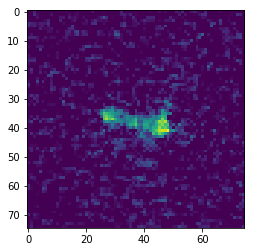

In [48]:
plt.imshow(conv1[0,:,:,56])

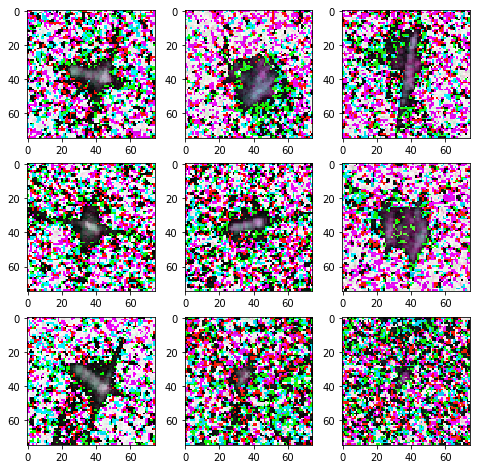

In [23]:
fig = plt.figure(figsize=(8,8))
for i in range(9):
    img = trn_data[i]
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img)

## VGG

In [407]:
from keras.applications import VGG19,VGG16

In [408]:
vgg = VGG16(include_top=False, input_shape=(75,75,3))

In [406]:
trn_features = vgg.predict(trn_data, batch_size=batch_size, verbose=1)
val_features = vgg.predict(val_data, batch_size=batch_size, verbose=1)

KeyboardInterrupt: 

In [416]:
def get_vgg_top(p):
    input1 = Input(shape=(2,2,512))
    x = Flatten()(input1)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(input1, x)
    model.compile(Adam(lr=1e-2), 'binary_crossentropy', ['accuracy'])
    
    return model

In [417]:
def remake():
    model = get_vgg_top(0.)
    full_model = model(vgg_out)
    augmodel = Model(vgg.input, full_model)
    augmodel.compile(Adam(1e-2), 'binary_crossentropy', ['accuracy'])
    
    return augmodel

In [423]:
vgg_out = vgg.layers[-1].output
for layer in vgg.layers: layer.trainable=False

In [424]:
model = remake()

In [425]:
gen = image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.0, rotation_range=0.0,
                               channel_shift_range=0.0, height_shift_range=0.0, zoom_range=0.0)
flow = gen.flow(trn_data, trn_labels, batch_size=batch_size)

In [426]:
model.compile(Adam(lr=1e-3), 'binary_crossentropy', ['accuracy'])

In [427]:
history1 = model.fit_generator(flow, steps_per_epoch=len(trn_data)/64, epochs=8, verbose=1, callbacks=[reduce_lr],
                               validation_data=(val_data, val_labels), validation_steps=len(val_data)/64)

Epoch 1/8


KeyboardInterrupt: 

In [55]:
history2 = model.fit(trn_data, trn_labels, epochs=5, batch_size=batch_size, callbacks=[reduce_lr], 
                     validation_data=(val_data, val_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/5
1203/1203 [==============================] - 286s 238ms/step - loss: 0.2715 - acc: 0.8753 - val_loss: 0.3072 - val_acc: 0.8703
Epoch 2/5
1203/1203 [==============================] - 288s 240ms/step - loss: 0.2732 - acc: 0.8811 - val_loss: 0.3038 - val_acc: 0.8753
Epoch 3/5
1024/1203 [========================>.....] - ETA: 32s - loss: 0.2662 - acc: 0.8818

KeyboardInterrupt: 

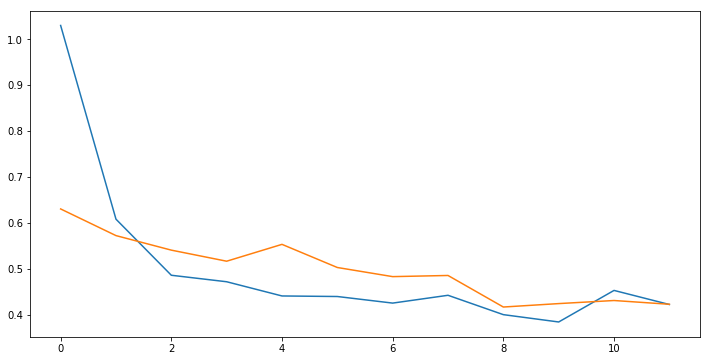

In [43]:
plt.figure(figsize=(12,6))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

## Data Augmentation

I just want a sample of the dataset to quickly test out some augmentation

In [264]:
def remake():
    model = get_vgg_top(0.)
    full_model = model(vgg_out)
    augmodel = Model(vgg.input, full_model)
    augmodel.compile(Adam(1e-2), 'binary_crossentropy', ['accuracy'])
    
    return augmodel

### Horizontal Flip Only

In [295]:
augmodel = remake()

In [296]:
gen = image.ImageDataGenerator(horizontal_flip=True)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [297]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=5, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/5
5/5 [==============================] - 82s 16s/step - loss: 1.4919 - acc: 0.7384 - val_loss: 0.6406 - val_acc: 0.7699
Epoch 2/5
5/5 [==============================] - 79s 16s/step - loss: 0.6535 - acc: 0.8046 - val_loss: 0.3867 - val_acc: 0.8230
Epoch 3/5
5/5 [==============================] - 79s 16s/step - loss: 0.4765 - acc: 0.7617 - val_loss: 2.0618 - val_acc: 0.6460
Epoch 4/5
5/5 [==============================] - 80s 16s/step - loss: 0.3500 - acc: 0.8219 - val_loss: 3.6492 - val_acc: 0.5133
Epoch 5/5
5/5 [==============================] - 77s 15s/step - loss: 0.3656 - acc: 0.8408 - val_loss: 2.9294 - val_acc: 0.5310


At least on the sample set, horizontal flipping doesn't seem to generalize well, still overfits

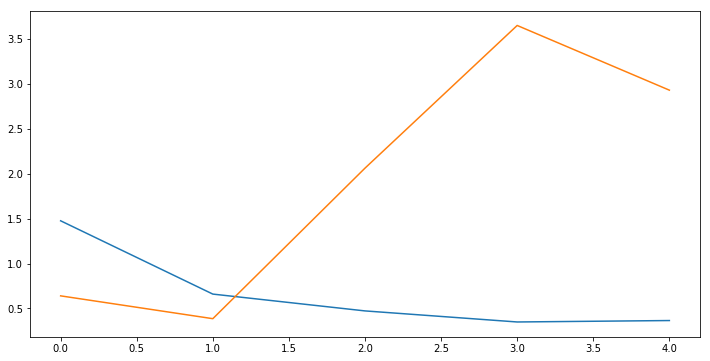

In [298]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### Vertical Flip Only

In [299]:
augmodel = remake()

In [300]:
gen = image.ImageDataGenerator(vertical_flip=True)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [301]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=5, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/5
5/5 [==============================] - 82s 16s/step - loss: 1.6043 - acc: 0.6972 - val_loss: 0.7913 - val_acc: 0.6903
Epoch 2/5
5/5 [==============================] - 81s 16s/step - loss: 0.6470 - acc: 0.7313 - val_loss: 1.1580 - val_acc: 0.6195
Epoch 3/5
5/5 [==============================] - 78s 16s/step - loss: 0.4802 - acc: 0.7644 - val_loss: 0.5935 - val_acc: 0.6549
Epoch 4/5
5/5 [==============================] - 79s 16s/step - loss: 0.3879 - acc: 0.8150 - val_loss: 3.0499 - val_acc: 0.4336
Epoch 5/5
5/5 [==============================] - 81s 16s/step - loss: 0.3565 - acc: 0.8250 - val_loss: 1.0047 - val_acc: 0.4956


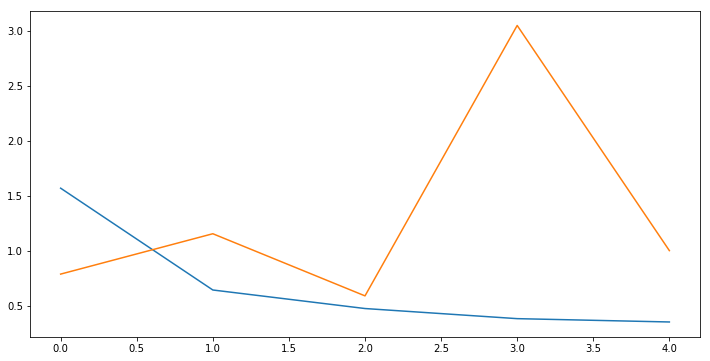

In [302]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### Rotation Range

In [303]:
augmodel = remake()

In [304]:
gen = image.ImageDataGenerator(rotation_range=30)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [277]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=3, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/3
5/5 [==============================] - 82s 16s/step - loss: 2.0094 - acc: 0.6434 - val_loss: 3.2436 - val_acc: 0.5221
Epoch 2/3
5/5 [==============================] - 79s 16s/step - loss: 0.6601 - acc: 0.7604 - val_loss: 0.5978 - val_acc: 0.6106
Epoch 3/3
5/5 [==============================] - 78s 16s/step - loss: 0.5381 - acc: 0.7600 - val_loss: 0.7126 - val_acc: 0.7080


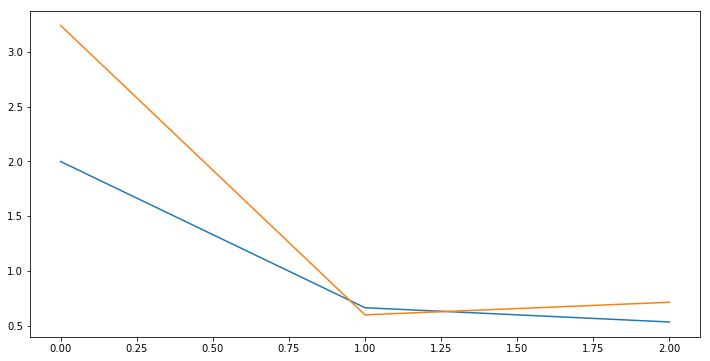

In [278]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### H Translation

In [305]:
augmodel = remake()

In [306]:
gen = image.ImageDataGenerator(width_shift_range=0.2)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [307]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=5, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/5
5/5 [==============================] - 83s 17s/step - loss: 1.8380 - acc: 0.6680 - val_loss: 2.4111 - val_acc: 0.5575
Epoch 2/5
5/5 [==============================] - 78s 16s/step - loss: 0.7927 - acc: 0.7732 - val_loss: 3.3554 - val_acc: 0.4248
Epoch 3/5
5/5 [==============================] - 79s 16s/step - loss: 0.5443 - acc: 0.7355 - val_loss: 1.5420 - val_acc: 0.4248
Epoch 4/5
5/5 [==============================] - 80s 16s/step - loss: 0.4235 - acc: 0.8063 - val_loss: 3.3855 - val_acc: 0.4248
Epoch 5/5
5/5 [==============================] - 79s 16s/step - loss: 0.4280 - acc: 0.7958 - val_loss: 7.8356 - val_acc: 0.4248


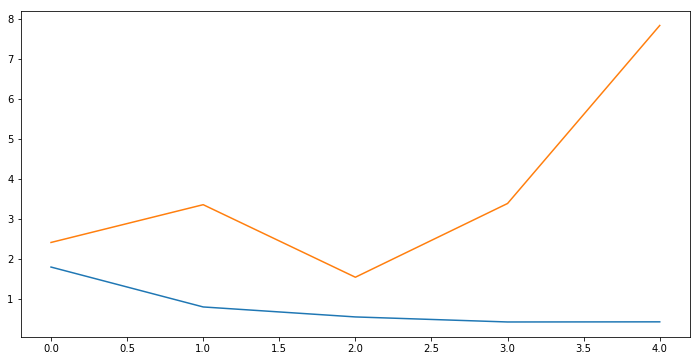

In [308]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### V Translation

In [309]:
augmodel = remake()

In [310]:
gen = image.ImageDataGenerator(height_shift_range=0.2)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [311]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=5, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/5
5/5 [==============================] - 85s 17s/step - loss: 2.0677 - acc: 0.6531 - val_loss: 1.4067 - val_acc: 0.6637
Epoch 2/5
5/5 [==============================] - 77s 15s/step - loss: 1.0650 - acc: 0.7177 - val_loss: 1.3346 - val_acc: 0.4248
Epoch 3/5
5/5 [==============================] - 81s 16s/step - loss: 0.5585 - acc: 0.7062 - val_loss: 1.2795 - val_acc: 0.7080
Epoch 4/5
5/5 [==============================] - 80s 16s/step - loss: 0.4287 - acc: 0.8364 - val_loss: 1.4252 - val_acc: 0.6283
Epoch 5/5
5/5 [==============================] - 79s 16s/step - loss: 0.4188 - acc: 0.8195 - val_loss: 1.1214 - val_acc: 0.5398


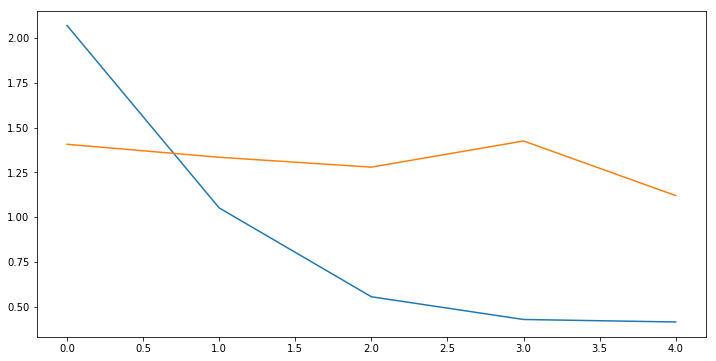

In [312]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### Zoom

In [287]:
augmodel = remake()

In [288]:
gen = image.ImageDataGenerator(zoom_range=0.2)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [289]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=3, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/3
5/5 [==============================] - 82s 16s/step - loss: 1.5496 - acc: 0.6474 - val_loss: 4.2423 - val_acc: 0.4248
Epoch 2/3
5/5 [==============================] - 79s 16s/step - loss: 0.6217 - acc: 0.7671 - val_loss: 1.6654 - val_acc: 0.5133
Epoch 3/3
5/5 [==============================] - 79s 16s/step - loss: 0.4295 - acc: 0.8019 - val_loss: 3.5349 - val_acc: 0.5752


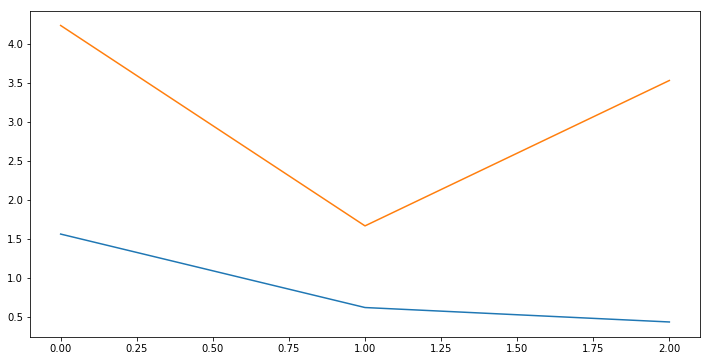

In [290]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### Channel Shift

In [ ]:
augmodel = remake()

In [291]:
gen = image.ImageDataGenerator(channel_shift_range=0.2)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [293]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=3, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

Epoch 1/3
5/5 [==============================] - 82s 16s/step - loss: 0.5980 - acc: 0.7411 - val_loss: 1.2341 - val_acc: 0.5929
Epoch 2/3
5/5 [==============================] - 79s 16s/step - loss: 0.4257 - acc: 0.8073 - val_loss: 0.7696 - val_acc: 0.7168
Epoch 3/3
5/5 [==============================] - 81s 16s/step - loss: 0.3269 - acc: 0.8563 - val_loss: 0.4135 - val_acc: 0.8584


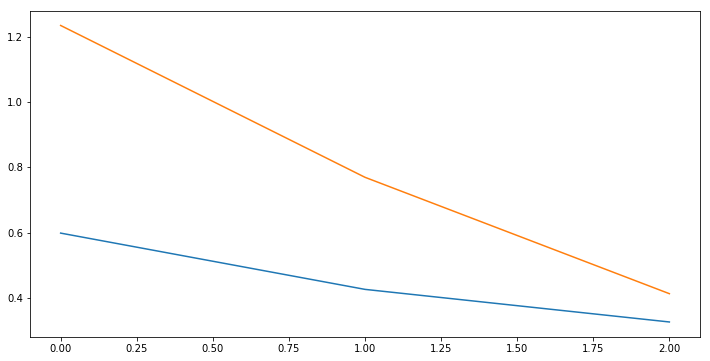

In [294]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

### ZCA Whitening

In [ ]:
augmodel = remake()

In [ ]:
gen = image.ImageDataGenerator(zca_whitening=True)
flow = gen.flow(trnd, trnl, batch_size=batch_size)

In [ ]:
history2 = augmodel.fit_generator(flow, steps_per_epoch=len(trnd)/64, epochs=3, verbose=1,
                                  validation_data=(vald, vall), validation_steps=len(vald)/64)

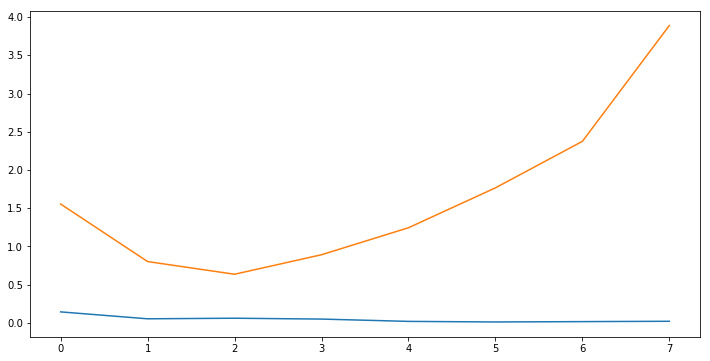

In [244]:
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

## XGBoost

In [22]:
import xgboost as xgb

In [236]:
from sklearn.preprocessing import scale
from sklearn.metrics import log_loss, accuracy_score

In [377]:
from PIL import Image, ImageStat

In [39]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [366]:
def get_correlation(i):
    #first try I'll take the 20 most correlated points and use them to make predictions, see if it does anything
    #need to make lists into arrays
    corr = pearsonr(np.sort(train.band_1[i])[-500:],np.sort(train.band_2[i])[-500:])
    
    return corr

In [367]:
corrs = np.array([get_correlation(i) for i in range(len(train))])

In [368]:
msk = np.random.random(len(train)) < 0.8

In [369]:
xgb_t_labels = train.is_iceberg[msk]
xgb_v_labels = train.is_iceberg[~msk]

In [370]:
dtrain = xgb.DMatrix(corrs[msk], label=xgb_t_labels)
dtest = xgb.DMatrix(corrs[~msk], label=xgb_v_labels)

In [371]:
param = {'max_depth': 3, 'objective':'binary:logistic', 'eval_metric':'logloss'}
num_round = 10

In [372]:
bst = xgb.train(params, dtrain, num_round)

In [373]:
preds = bst.predict(dtest)

In [374]:
log_loss(xgb_v_labels, preds)

0.71742638027686689

In [375]:
accuracy_score(xgb_v_labels,np.round(preds))

0.51724137931034486